Imports

In [11]:
import numpy as np
import torch
from torch import nn
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import random
import torch.optim as optim

Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {torch.cuda.get_device_name(device)}")

Device: NVIDIA GeForce GTX 1650 Ti


Directory Preparation

In [3]:
input_path = "C:/Users/steph/OneDrive/Documents/University/Research/VIL/Thesis Project/Data/Train_H5/slices"
target_path = "C:/Users/steph/OneDrive/Documents/University/Research/VIL/Thesis Project/Data/Train_H5/target_slice_images"
input_data = os.listdir(input_path)
target_data = os.listdir(target_path)

Data Preparation Helper Functions

In [4]:
def get_target(input_file : str):
    '''
    Returns the target reconstruction filename for the input image

    Parameters
    ----------
    input_file : str
        Input file string name
    '''
    id = "_".join(input_file.split(".")[0].split("_"))
    for target_file in target_data:
        if id in target_file:
            return target_file
    raise ValueError("No match in target data")

def get_patient_ids(data : list):
    '''
    Returns the different patient ids for the dataset (to split according to dataset)

    Parameters
    ----------
    data : list
        List of patient ids (which are strings)
    '''
    to_return = []
    for file in data:
        if not file.split("_")[1] in to_return:
            to_return.append(file.split("_")[1])
    return(to_return)

def load_file_data(folder : str, file : str) -> np.ndarray:
    '''
    Returns the np.ndarray of the queried file

    Parameters
    ----------
    folder : str
        Directory name where the queried file is
    file : str
        Name of the file

    Returns
    -------
    out : np.ndarray:
        Numpy array of shape (218, 170, 12) or (218, 180, 12) containing complex raw k-space data
    
    '''
    try:
        out = np.load(os.path.join(folder, file))
    except:
        raise ValueError("Loading file failed")
    
    return out
    
def subset_data_by_patient_id(data : list) -> list:
    '''
    Returns a dictionary mapping each patient id to their slices.
    For use in train/validation/test splitting.

    Parameters
    ----------
    data : list
        List of slices in a folder to be subsetted

    Returns
    -------
    dic : dict
        Dictionary that maps patient ID to a list containing their slices

    '''
    patient_ids = get_patient_ids(data)
    dic = {}
    for id in patient_ids:
        slices = []
        for x in data:
            if id in x:
                slices.append(x)
        dic[id] = slices
    return(dic)

def get_slices_from_ids(ids: list, id_slice_dic : dict) -> list:
    '''
    Returns a list holding all slices from the patient ids included in the passed list ids

    Parameters
    ----------
    ids : list
        Patient IDs being queried
    id_slice_dic : dict
        Dictionary mapping patient IDs to their slices. Output of the subset_data_by_patient_id function

    Returns
    -------
    slices : list
        List of slice file names from the patients included in ids
    '''

    slices = []
    for id in ids:
        slices.extend(id_slice_dic[id])
    return slices

def undersample_r4(input : torch.Tensor):
    '''
    Generates uniformly undersampled input data by a factor of 4

    Parameters
    ----------
    input : torch.Tensor
        Fully sampled input data. Assumed shape is (ky, kx, channels)

    Returns
    -------
    input : torch.Tensor
        Undersampled input data

    '''
    input[:, ::4, :] = 0
    input[:, 1::4, :] = 0
    input[:, 2::4, :] = 0
    return input

def undersample_r8(input : torch.Tensor):
    '''
    Generates uniformly undersampled input data by a factor of 8

    Parameters
    ----------
    input : torch.Tensor
        Fully sampled input data. Assumed shape is (ky, kx, channels)

    Returns
    -------
    input : torch.Tensor
        Undersampled input data
    '''
    input[:, ::8, :] = 0
    input[:, 1::8, :] = 0
    input[:, 2::8, :] = 0
    input[:, 3::8, :] = 0
    input[:, 4::8, :] = 0
    input[:, 5::8, :] = 0
    input[:, 6::8, :] = 0
    return input

Dataset Construction

In [5]:
# Num patients in train/val/test subsets - small for preliminary results
num_patients_train = 8
num_patients_val = 2
num_patients_test = 8

patient_id_groups = subset_data_by_patient_id(input_data)
patient_ids = list(patient_id_groups.keys())

print(f"Total data available includes {len(input_data)} slices from {len(patient_ids)} patients")

random.shuffle(patient_ids) # Shuffle patient ids for random distribution

if (num_patients_train + num_patients_val + num_patients_test <= len(patient_ids)):
    train_ids = patient_ids[0:num_patients_train]
    val_ids = patient_ids[(num_patients_train + 1):(num_patients_train + 1 + num_patients_val)]
    test_ids = patient_ids[(num_patients_train + 1 + num_patients_val + 1):(num_patients_train + 1 + num_patients_val + 1+ num_patients_test)]
else: 
    raise ValueError("Not enough patients for the number in split proposed")

print(f"Number of slices in training subset: {len(get_slices_from_ids(train_ids, patient_id_groups))}")
print(f"Number of slices in validation subset: {len(get_slices_from_ids(val_ids, patient_id_groups))}")
print(f"Number of slices in test subset: {len(get_slices_from_ids(test_ids, patient_id_groups))}")
    
class MDSC523_Final_Project_DS(Dataset):
    def __init__(self, slices, acceleration_factor : int, input_path, target_path):
        self.slices = slices
        self.acceleration_factor = acceleration_factor
        self.input_path = input_path
        self.target_path = target_path

    def __len__(self):
        return len(self.slices)
    
    def process_input(self, slice_index : int) -> torch.Tensor:
        '''
        Helper function which processes a slice query index and returns the processed data

        Parameters
        ----------
        slice : index
            Index into self.slices to query particular slice
        
        Returns
        -------
        mag : torch.Tensor
            Undersampled magnitude image. Shape will be (1, 218, 170)
        '''

        input_data = torch.tensor(load_file_data(self.input_path, self.slices[slice_index]))[:, :170, :]
        assert input_data.shape == (218, 170, 12), f"Input data is of shape {input_data.shape}, not (218, 170, 12) as required"

        if self.acceleration_factor == 4:
            undersampled = undersample_r4(input_data)
        elif self.acceleration_factor == 8:
            undersampled = undersample_r8(input_data)
        else:
            raise ValueError("Unsupported acceleration factor selected")
        
        shifted = torch.fft.ifftshift(undersampled, dim = (0, 1)) # IFFT shift the undersampled data
        transformed = torch.fft.ifft2(shifted, dim = (0, 1)) # Apply IFFT the shifted, undersampled data
        rss = torch.sqrt(torch.sum(transformed**2, dim = 2)) # Get complex RSS of transformed
        mag = torch.abs(rss) # Get magnitude image
        
        assert mag.shape == (218, 170), f"Magnitude shape is {mag.shape} when it should be (218, 170)"

        mag.view(1, 218, 170) # Reshape mag to be compatible with torch batch etc.
        
        return mag
    
    def process_target(self, slice_index : int) -> torch.Tensor:
        '''
        Helper function which processes the target for a slice query

        Parameters
        ----------
        slice_index : int
            Index into self.slices to query particular slice

        Returns
        -------
        mag : torch.Tensor
            Target magnitude image. Shape will be (1, 218, 170)
        '''


        target_data = torch.tensor(load_file_data(self.target_path, get_target(self.slices[slice_index])))[:, :, :170]

        assert target_data.shape == (1, 218, 170), f"Target data shape {target_data.shape} does not match expected shape (218, 170)"

        mag = torch.abs(target_data) # Get magnitude data

        mag.view(1, 218, 170) # Reshape mag to be compatible with torch batch etc.

        return mag
    
    def __getitem__(self, index):
        to_return = {
            'input': self.process_input(index),
            'target' : self.process_target(index)
        }
        return to_return

Total data available includes 12032 slices from 42 patients
Number of slices in training subset: 3072
Number of slices in validation subset: 512
Number of slices in test subset: 2048


In [6]:
def build_exp_ds(r4_ratio, train_ids, val_ids, test_ids, patient_id_groups, input_path, target_path):
    '''
    Function to build an experimental dataset depending on the ratio of acceleration factor = 4

    Parameters
    ----------
    r4_ratio : double
        Proportion of data designated to be undersampled at a four-time rate (as opposed to R = 8)
    train_ids : list
        List of patient ids (str) designated for training
    val_ids : list
        List of patient ids (str) desginated for validation
    test_ids : list
        List of patient ids (str) designated for testing
    patient_id_groups : dict
        Dictionary mapping patient ids to their slices 

    Returns
    -------
    out : dict
        Dictionary containing maps to 'train', 'val', 'test_r4', and 'test_r8' datasets 
    '''

    out = {} # Iniitalize dicionary to eventually output

    # Get train, validation, and test designated slices 
    train_slices = get_slices_from_ids(train_ids, patient_id_groups)
    random.shuffle(train_slices)
    val_slices = get_slices_from_ids(val_ids, patient_id_groups)
    random.shuffle(val_slices)
    test_slices = get_slices_from_ids(test_ids, patient_id_groups)
    random.shuffle(test_slices)

    # Build train dataset
    train_r4 = MDSC523_Final_Project_DS(train_slices[:int(r4_ratio * len(train_slices))],
                                        4, input_path, target_path)
    train_r8 = MDSC523_Final_Project_DS(train_slices[int(r4_ratio * len(train_slices)):],
                                        8, input_path, target_path)
    out['train'] = ConcatDataset([train_r4, train_r8])

    # Build val dataset
    val_r4 = MDSC523_Final_Project_DS(val_slices[:int(r4_ratio * len(val_slices))],
                                      8, input_path, target_path)
    val_r8 = MDSC523_Final_Project_DS(val_slices[int(r4_ratio * len(val_slices)):],
                                      8, input_path, target_path)
    out['val'] = ConcatDataset([val_r4, val_r8])

    # Build test_r4
    out['test_r4'] = MDSC523_Final_Project_DS(test_slices[:int(len(test_slices) / 2)],
                                              4, input_path, target_path)
    
    # Build test_r8
    out['test_r8'] = MDSC523_Final_Project_DS(test_slices[int(len(test_slices) / 2):],
                                              8, input_path, target_path)
    
    return out

Dataloader

In [7]:
def build_exp_dls(train_ds, val_ds, test_r4_ds, test_r8_ds, batch_size):
    '''
    Function to build the dataloaders

    Parameters
    ----------
    train_ds:
        Training dataset
    val_ds:
        Validation dataset
    test_r4_ds:
        Testing dataset (R = 4)
    test_r8_ds:
        Testing dataset (R = 8)
    batch_size:
        Batch size to use for dataloaders

    Returns
    -------
    out : dict
        Dicionary mapping 'train', 'val', test_r4', and test_r8' to their respective dataloaders
    '''

    out = {}
    out['train'] = DataLoader(train_ds, batch_size, shuffle = True)
    out['val'] = DataLoader(val_ds, batch_size, shuffle = True)
    out['test_r4'] = DataLoader(test_r4_ds, batch_size, shuffle = True)
    out['test_r8'] = DataLoader(test_r8_ds, batch_size, shuffle = True)

    return out

Model

In [8]:
class UNet(nn.Module):
    def __init__(self):
        '''
        Initialize U-Net model within the SME

        Parameters
        ----------
        ch_in:
            Number of input channels
        ch_out:
            Number of output channels  
        '''
        super().__init__()
        self.network = nn.Sequential(

            # Contracting Portion:
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bottleneck:
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2),

            # Expansive Portion:
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2),
            
            nn.Conv2d(16, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size = 1, padding = 1)

        )

    def forward(self, input):
        b, dy, dx = input.shape
        correct_shape = input.view(b, 1, dy, dx)
        return self.network(correct_shape)

In [ ]:

import torch.nn.functional as F

# Instantiate your UNet model
test_exp1_model = UNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_exp1_model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(test_exp1_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Set the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    test_exp1_model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch in exp1_dls['train']:
        inputs, targets = batch['input'].to(device), batch['target'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = test_exp1_model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss for the epoch
    average_train_loss = running_loss / len(exp1_dls['train'])

    # Validation loop
    test_exp1_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for batch in exp1_dls['val']:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)

            # Forward pass
            outputs = test_exp1_model(inputs)

            # Calculate the loss
            loss = criterion(outputs, targets)

            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    average_val_loss = val_loss / len(exp1_dls['val'])

    # Print the current epoch and losses
    print(f'Epoch {epoch + 1}/{num_epochs} => Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')


Training Function

In [20]:
def train(device, model, criterion, num_epochs, train_dl, val_dl):

    seed = 99
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)

    loss_data = {'training loss' : [], 'validation loss' : []}

    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for batch in train_dl:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)

            optimizer.zero_grad() # Zero gradients

            outputs = model(inputs) # Forward Pass

            loss = criterion(outputs, targets) # Loss Calculation

            loss.backward() # Backward Pass
            optimizer.step() # Optimization

            running_loss += loss.item()

        # Calculate average training loss for the epoch
        average_train_loss = running_loss / len(train_dl)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dl:
                inputs, targets = batch['input'].to(device), batch['target'].to(device)

                outputs = model(inputs) # Forward pass

                loss = criterion(outputs, targets) # Loss calculation

                val_loss += loss.item()

        # Calculate average validation loss for the epoch
        average_val_loss = val_loss / len(val_dl)

        # Print the current epoch and losses
        print(f'Epoch {epoch + 1}/{num_epochs} => Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

        loss_data['training loss'].append(average_train_loss)
        loss_data['validation loss'].append(average_val_loss)

    return loss_data

def run_experiments(batch_size : int, arms : dict, train_ids : list, val_ids : list, test_ids : list,
                    input_path : str, target_path : str, device : torch.device, criterion):
    '''
    Builds, runs, and stores experiment

    Parameters
    ----------
    batch_size : int
        Minibatch size to use in model training
    arms : dict
        Dictionary representing the experimental arms. Maps experimental arm name (str) to its 
        proportion of R = 4 accelerated training and validation data
    train_ids : list
        List of the training-designated patient IDs
    val_ids : list
        List of the validation-designated patient IDs
    test_ids : list
        List of the test-designated patient IDs
    patient_id_groups : dict
        Dictionary mapping patient IDs to their slices
    input_path : str
        Directory containing input data
    target_path : str
        Directory containing target data
    num_epochs : int
        Number of epochs to use during training
    device : torch.device
        Device to train models on
    optimizer
        Optimizer to use for training
    criterion
        Training criterion

    Returns
    -------
    results : dict
        Dictionary mapping experimental arm name to results
    '''

    results = {} # Initialize empty results dictionary

    for arm in arms.keys(): # For each 

        exp_ds = build_exp_ds(arms[arm], train_ids, val_ids, test_ids, patient_id_groups,
                              input_path, target_path)
        exp_dl = build_exp_dls(exp_ds['train'], exp_ds['val'], exp_ds['test_r4'], exp_ds['test_r8'], batch_size)

        exp_model = UNet()

        print(f"Training experimental arm {arm}")

        exp_loss_data = train(device, exp_model, criterion, num_epochs, exp_dl['train'], exp_dl['val'])  

        to_append = {'model' : exp_model, 'loss_data' : exp_loss_data, 'datasets' : exp_ds, 'dataloaders' : exp_dl}   

        results[arm] = to_append   

    print('Experimental procedure completed')

    return results


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
num_epochs = 10
batch_size = 32
arms = {'r4=0' : 0, 'r4=0.25' : 0.25, 'r4=0.5' : 0.5, 'r4=0.75' : 0.75, 'r4=1' : 1}

results = run_experiments(batch_size, arms, train_ids, val_ids, test_ids, input_path, 
                          target_path, device, criterion)

Training experimental arm r4=0
Epoch 1/10 => Training Loss: 0.1907, Validation Loss: 0.1250
Epoch 2/10 => Training Loss: 0.1064, Validation Loss: 0.0946
Epoch 3/10 => Training Loss: 0.0928, Validation Loss: 0.0899
Epoch 4/10 => Training Loss: 0.0905, Validation Loss: 0.0881
Epoch 5/10 => Training Loss: 0.0893, Validation Loss: 0.0874
Epoch 6/10 => Training Loss: 0.0887, Validation Loss: 0.0875
Epoch 7/10 => Training Loss: 0.0882, Validation Loss: 0.0872
Epoch 8/10 => Training Loss: 0.0876, Validation Loss: 0.0861
Epoch 9/10 => Training Loss: 0.0872, Validation Loss: 0.0864
Epoch 10/10 => Training Loss: 0.0872, Validation Loss: 0.0863
Training experimental arm r4=0.25
Epoch 1/10 => Training Loss: 0.1696, Validation Loss: 0.1302
Epoch 2/10 => Training Loss: 0.1047, Validation Loss: 0.0959
Epoch 3/10 => Training Loss: 0.0935, Validation Loss: 0.0904
Epoch 4/10 => Training Loss: 0.0899, Validation Loss: 0.0883
Epoch 5/10 => Training Loss: 0.0883, Validation Loss: 0.0878
Epoch 6/10 => Train

In [26]:
print(results.keys())
results['r4=0'].keys()
results['r4=0']['dataloaders']

dict_keys(['r4=0', 'r4=0.25', 'r4=0.5', 'r4=0.75', 'r4=1'])


{'train': <torch.utils.data.dataloader.DataLoader at 0x20f56d78290>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x20f56c9d310>,
 'test_r4': <torch.utils.data.dataloader.DataLoader at 0x20f56d7bbd0>,
 'test_r8': <torch.utils.data.dataloader.DataLoader at 0x20f56d79c50>}

Testing 

In [28]:
test_r4_dl = results['r4=0']['dataloaders']['test_r4']
test_r8_dl = results['r4=0']['dataloaders']['test_r8']

test_reconstruction_performance = {}

for key in results.keys():
    test_loss_r4 = []
    test_loss_r8 = []

    results[key]['model'].to(device)
    results[key]['model'].eval()

    with torch.no_grad():
        for batch in test_r4_dl:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)

            outputs = results[key]['model'](inputs)

            loss = criterion(outputs, targets)

            test_loss_r4.append(loss.item())

        for batch in test_r8_dl:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)

            outputs = results[key]['model'](inputs)

            loss = criterion(outputs, targets)

            test_loss_r8.append(loss.item())
    
    print(f"Arm {key} testing completed")

    to_append = {'test_r4_losses' : test_loss_r4,
                 'test_r8_losses' : test_loss_r8}
    test_reconstruction_performance[key] = to_append


Arm r4=0 testing completed
Arm r4=0.25 testing completed
Arm r4=0.5 testing completed
Arm r4=0.75 testing completed
Arm r4=1 testing completed


Statistical Analysis

In [49]:
from scipy.stats import kruskal
import scikit_posthocs as sp
import pandas as pd

In [34]:
for key in test_reconstruction_performance.keys():
    print(key)
    print(test_reconstruction_performance[key].keys())

r4=0
dict_keys(['test_r4_losses', 'test_r8_losses'])
r4=0.25
dict_keys(['test_r4_losses', 'test_r8_losses'])
r4=0.5
dict_keys(['test_r4_losses', 'test_r8_losses'])
r4=0.75
dict_keys(['test_r4_losses', 'test_r8_losses'])
r4=1
dict_keys(['test_r4_losses', 'test_r8_losses'])


In [39]:
statistic_r4, p_value_r4 = kruskal(test_reconstruction_performance['r4=0']['test_r4_losses'],
                             test_reconstruction_performance['r4=0.25']['test_r4_losses'],
                             test_reconstruction_performance['r4=0.5']['test_r4_losses'],
                             test_reconstruction_performance['r4=0.75']['test_r4_losses'],
                             test_reconstruction_performance['r4=1']['test_r4_losses'],)

In [42]:
print(f"Kruskal-Wallis H-statistic (R = 4): {statistic_r4}")
print(f"P-value (R = 4): {p_value_r4}")

Kruskal-Wallis H-statistic (R = 4): 36.53338509316768
P-value (R = 4): 2.2474156018205592e-07


In [41]:
statistic_r8, p_value_r8 = kruskal(test_reconstruction_performance['r4=0']['test_r8_losses'],
                             test_reconstruction_performance['r4=0.25']['test_r8_losses'],
                             test_reconstruction_performance['r4=0.5']['test_r8_losses'],
                             test_reconstruction_performance['r4=0.75']['test_r8_losses'],
                             test_reconstruction_performance['r4=1']['test_r8_losses'],)

In [43]:
print(f"Kruskal-Wallis H-statistic (R = 8): {statistic_r8}")
print(f"P-value (R = 8): {p_value_r8}")

Kruskal-Wallis H-statistic (R = 8): 1.343594720496867
P-value (R = 8): 0.853936837284137


In [47]:
print(len(test_reconstruction_performance['r4=0']['test_r4_losses']))

32


In [54]:
r4_data = [test_reconstruction_performance['r4=0']['test_r4_losses'],
          test_reconstruction_performance['r4=0.25']['test_r4_losses'],
          test_reconstruction_performance['r4=0.5']['test_r4_losses'],
          test_reconstruction_performance['r4=0.75']['test_r4_losses'],
          test_reconstruction_performance['r4=1']['test_r4_losses']]
sp.posthoc_dunn(r4_data, p_adjust = 'bonferroni')

,1,2,3,4,5
1,1.000000,0.029481,0.000263,0.000010,0.000001
2,0.029481,1.000000,1.000000,0.547427,0.190534
3,0.000263,1.000000,1.000000,1.000000,1.000000
4,0.000010,0.547427,1.000000,1.000000,1.000000
5,0.000001,0.190534,1.000000,1.000000,1.000000


In [62]:
r4_means = []
r4_medians = []
r8_means = []
r8_medians = []
for key in test_reconstruction_performance.keys():
    r4_means.append(np.mean(test_reconstruction_performance[key]['test_r4_losses']))
    r8_means.append(np.mean(test_reconstruction_performance[key]['test_r8_losses']))
    r4_medians.append(np.median(test_reconstruction_performance[key]['test_r4_losses']))
    r8_medians.append(np.median(test_reconstruction_performance[key]['test_r8_losses']))
print(f"R = 4 Means: {r4_means}")
print(f"R = 8 Means: {r8_means}")
print(f"R = 4 Medians: {r4_medians}")
print(f"R = 8 Medians: {r8_medians}")

R = 4 Means: [0.08695061854086816, 0.08256971486844122, 0.08127056551165879, 0.08017014153301716, 0.07942521059885621]
R = 8 Means: [0.08892490738071501, 0.08879910479299724, 0.08904915628954768, 0.08898938703350723, 0.08993930835276842]
R = 4 Medians: [0.08638937398791313, 0.08335299044847488, 0.08067915961146355, 0.08000850304961205, 0.07971400395035744]
R = 8 Medians: [0.08900239318609238, 0.08677000552415848, 0.0895446203649044, 0.08849955350160599, 0.08952498435974121]


Plots

In [ ]:
import matplotlib.pyplot as plt

Boxplot displaying results across experiments

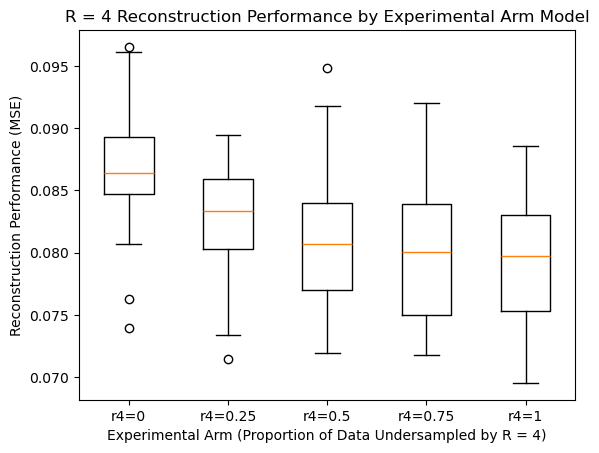

In [61]:
fig = plt.figure()

plt.boxplot([test_reconstruction_performance['r4=0']['test_r4_losses'], 
             test_reconstruction_performance['r4=0.25']['test_r4_losses'],
             test_reconstruction_performance['r4=0.5']['test_r4_losses'],
             test_reconstruction_performance['r4=0.75']['test_r4_losses'],
             test_reconstruction_performance['r4=1']['test_r4_losses']],
            labels = [key for key in test_reconstruction_performance.keys()])
plt.title('R = 4 Reconstruction Performance by Experimental Arm Model')
plt.xlabel('Experimental Arm (Proportion of Data Undersampled by R = 4)')
plt.ylabel('Reconstruction Performance (MSE)')

plt.show()

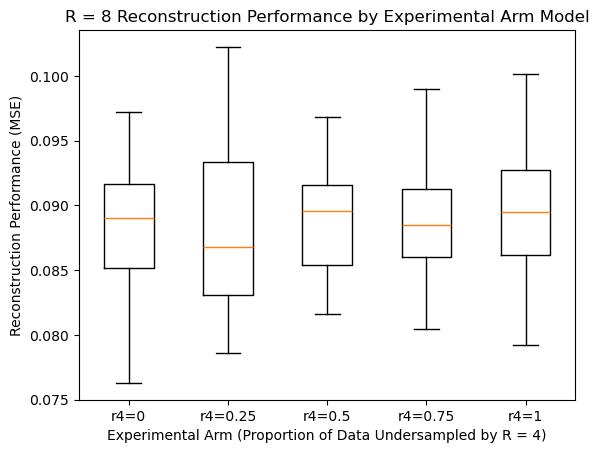

In [64]:
fig = plt.figure()

plt.boxplot([test_reconstruction_performance['r4=0']['test_r8_losses'], 
             test_reconstruction_performance['r4=0.25']['test_r8_losses'],
             test_reconstruction_performance['r4=0.5']['test_r8_losses'],
             test_reconstruction_performance['r4=0.75']['test_r8_losses'],
             test_reconstruction_performance['r4=1']['test_r8_losses']],
            labels = [key for key in test_reconstruction_performance.keys()])
plt.title('R = 8 Reconstruction Performance by Experimental Arm Model')
plt.xlabel('Experimental Arm (Proportion of Data Undersampled by R = 4)')
plt.ylabel('Reconstruction Performance (MSE)')

plt.show()